<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/DIFFUSION-DIFFUSER-LIB/blob/main/training_a_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Generation with Diffusion Models on the Stanford Cars Dataset

### Introduction

In recent years, diffusion models have emerged as a powerful class of generative models, capable of producing high-quality images by learning to reverse a gradual noising process. These models have shown remarkable success in tasks such as image synthesis, inpainting, and super-resolution. In this notebook, we explore the implementation of a diffusion model applied to the **Stanford Cars Dataset**, a collection of 16,185 images of cars from 196 classes.

The goal of this project is to train a diffusion model to generate realistic images of cars by learning the underlying data distribution. We will implement a Denoising Diffusion Probabilistic Model (DDPM) from scratch using PyTorch, and demonstrate how the model can progressively denoise random noise to produce coherent and visually appealing car images.

### **Installing and Importing Required Libraries**
We installed the following libraries using `pip`:
- **`diffusers`**: A library by Hugging Face for diffusion models, providing pre-built components like UNet architectures and schedulers.
- **`datasets`**: A library for easily loading and processing datasets.
- **`transformers`**: A library for natural language processing and other tasks, often used alongside diffusion models.

In [ ]:
!pip install -qq -U diffusers datasets transformers accelerate

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms
from datasets import load_dataset
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from diffusers import UNet2DModel

utility functions for plotting images

In [ ]:
def show_images(x, NR=8):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow= NR)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

setting device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
import kagglehub
import shutil
import os

# Step 1: Download the dataset (it will go to the default cache location)
dataset_path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

# Step 2: Define your custom directory
custom_download_path = "/content"

# Step 3: Move or copy the dataset to the custom directory
if not os.path.exists(custom_download_path):
    os.makedirs(custom_download_path)

# Copy the dataset to the custom location
shutil.copytree(dataset_path, os.path.join(custom_download_path, "stanford-cars-dataset"))

print(f"Dataset has been copied to: {custom_download_path}")

100%|██████████| 1.82G/1.82G [00:19<00:00, 102MB/s] 

Extracting files...


Dataset has been copied to: /content


### **Preprocessing and Preparing Dataset**

In [ ]:
# dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
dataset = load_dataset("imagefolder", data_dir="/content/stanford-cars-dataset/cars_train/cars_train")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 64
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        # transforms.RandomRotation(15),  # Randomly rotate *
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust color *
        # transforms.RandomCrop(image_size, padding=4),  # Random cropping *
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/8144 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

X shape: torch.Size([8, 3, 64, 64])


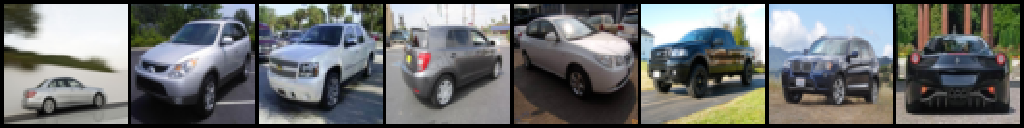

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((16 * 64, 2 * 64), resample=Image.NEAREST)

setting up and testing sampler

In [ ]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=500)

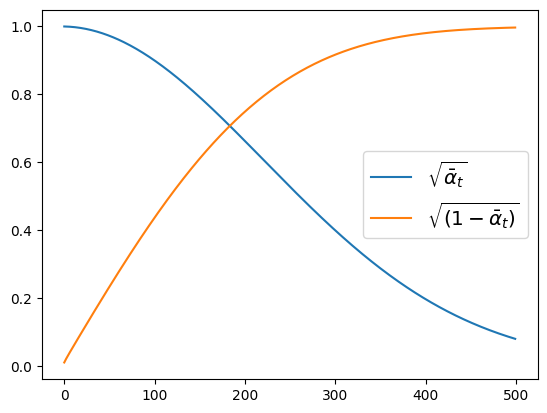

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

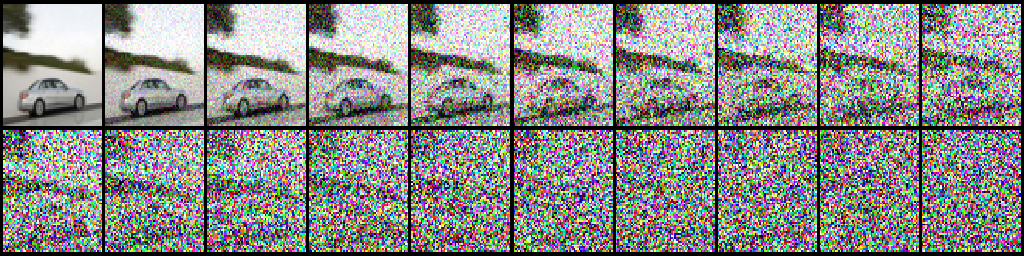

In [ ]:
# Assuming xb is your input image tensor and noise_scheduler is your noise scheduler
# Example: xb is a batch of images with shape (8, 3, 32, 32)

# Define timesteps at intervals of 5
timesteps = torch.linspace(0, 499, 20).long().to(device)  # 20 steps from 0 to 99

# Select a single image from the batch (e.g., the first image)
single_image = xb[0].unsqueeze(0)  # Shape: [1, 3, 32, 32]

# # Initialize a tensor to store the noisy images
noisy_images = []

# # Add noise to the image at the selected timesteps
for t in timesteps:
    noise = torch.randn_like(single_image)  # Generate random noise
    noisy_xb = noise_scheduler.add_noise(single_image, noise, t.unsqueeze(0))  # Add noise at step t
    noisy_images.append(noisy_xb)

# # Stack the noisy images into a single tensor
noisy_images = torch.cat(noisy_images, dim=0)

# # Visualize the noisy images (only one image per 5 steps)
show_images(noisy_images, NR= 10).resize((16 * 64, 4*64), resample=Image.NEAREST)

### **Creating Model for Diffusion**

In [ ]:
# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

### **Training Model**

In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=500, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Initialize GradScaler for mixed precision training
scaler = GradScaler(device="cuda")  # Specify device_type as "cuda"

losses = []
EPOCHS = 50
for epoch in range(EPOCHS):
    # Wrap the train_dataloader with tqdm for a progress bar
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)

    for step, batch in enumerate(progress_bar):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass with autocast for mixed precision
        with autocast(device_type="cuda"):  # Specify device_type as "cuda"
            # Get the model prediction
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

            # Calculate the loss
            loss = F.mse_loss(noise_pred, noise)

        # Backward pass with GradScaler
        scaler.scale(loss).backward()

        # Update the model parameters with the optimizer
        scaler.step(optimizer)

        # Update the GradScaler for the next iteration
        scaler.update()

        # Record the loss
        losses.append(loss.item())

        # Update the progress bar description with the current loss
        progress_bar.set_postfix(loss=loss.item())

Epoch 50/50: 100%|██████████| 128/128 [01:48<00:00,  1.18it/s, loss=0.0281]


### **Ploting and Testing Model**

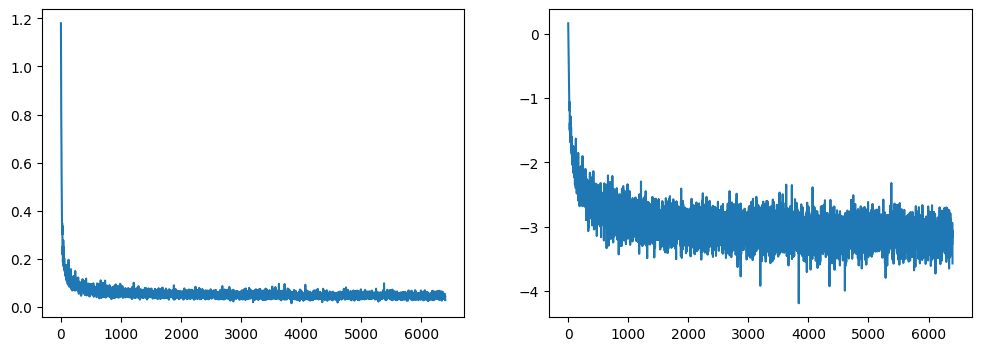

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

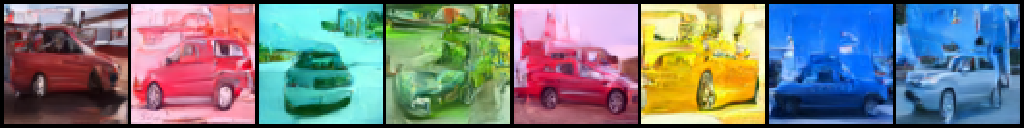

In [ ]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 64, 64).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample).resize((16 * 64, 2 * 64), resample=Image.NEAREST)